<a href="https://colab.research.google.com/github/george-zakharov/ml_notebooks/blob/master/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework Energy Star Score

Датасет взят с сайта: https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml

### Light: 

- построить модель используя LinearRegression для предсказания энергопотребления зданий в Нью-Йорке;

- использовать инструметы нормализации/стандартизации признаков;

- использовать по крайней мере один из способов отбора признаков (см. блокнот с вебинара).

### Pro:

- построить модель используя LinearRegression, LinearSVR для предсказания энергопотребления зданий в Нью-Йорке;

- произвести нормализацию признаков в случае необходимости;

- использовать все инструменты для отбора признаков;

- ответить на вопрос: какие 5 признаков оказывают наибольшее влияние на целевой параметр 'ENERGY STAR Score'?

# Load libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.model_selection import train_test_split


import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, LassoCV, Lasso, Ridge, SGDRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVR

import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Загрузка и очистка данных

In [0]:
# Read in data into a dataframe 
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML/4/Блокноты/Homework 4/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

In [4]:
# Display top of dataframe
data.head(3)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...


## Типы данных и пропуски

In [5]:
# See the column data types and non-missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

## Конвертация данных

In [0]:
# Replace all occurrences of Not Available with numpy not a number
data = data.replace({'Not Available': np.nan})

# Iterate through the columns
for col in list(data.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        data[col] = data[col].astype(float)

In [7]:
# Статистика каждого признака
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1.321000e+03,5.940000e+02,1.600000e+01,9.360000e+02,1.030400e+04,9.784000e+03,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,280.071484,309.747466,11.072643,1.901441,417.915709,3.395398e+06,3.186882e+06,5.294367e+06,2.429105e+06,1.193594e+06,2.868907e+08,5.048545e+07,5.364578e+05,5.965472e+06,1.768752e+06,4.553657e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,8607.178877,9784.731207,127.733868,97.204587,10530.524339,2.213237e+06,5.497154e+06,5.881863e+06,4.442946e+06,3.558178e+06,3.124603e+09,3.914719e+09,4.022606e+07,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.800000,65.100000,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2.128213e+06,0.000000e+00,5.698020e+04,4.320254e+06,1.098251e+06,1.176952e+04,1.043673e+06,3.019974e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.400000,4.328815e+06,1.380138e+06,4.312984e+06,0.000000e+00,2.070020e+05,9.931240e+06,4.103962e+06,4.445525e+04,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.600000,102.500000,9.200000,0.700000,167.200000,4.938947e+06,4.445808e+06,6.514520e+06,4.293825e+06,2.918332e+0

## Заполняем пропуски 

In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


## Сохраним только те колонки, у которых менее 50 процентов пропусков

In [11]:
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [0]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

## Простой вариант предобработки данных

In [30]:
# Copy the original data
features = data.copy()

# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(11746, 116)

In [22]:
features.head()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract,log_Order,log_Property Id,log_DOF Gross Floor Area,log_Largest Property Use Type - Gross Floor Area (ft²),log_Year Built,log_Number of Buildings - Self-reported,log_Occupancy,log_ENERGY STAR Score,log_Site EUI (kBtu/ft²),log_Weather Normalized Site EUI (kBtu/ft²),log_Weather Normalized Site Electricity Intensity (kWh/ft²),...,Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Laboratory,Largest Property Use Type_Library,Largest Property Use Type_Mailing Center/Post Office,Largest Property Use Type_Manufacturing/Industrial Plant,Largest Property Use Type_Medical Office,Largest Property Use Type_Movie Theater,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Office,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Other - Technology/Science,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,1,13286,289356.0,293447.0,1963,2,100,NaN,305.6,303.1,37.8,NaN,614.2,NaN,NaN,38139374.2,11082770.5,6962.2,0.0,6962.2,762051.0,NaN,NaN,619.4,40.750791,-73.973963,6.0,4.0,88.0,0.000000,9.494466,12.575413,12.589452,7.582229,0.693147,4.60517,NaN,5.722277,5.714063,3.632309,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,28400,3693539.0,3889181.0,1969,12,100,55.0,229.8,228.8,24.8,2.4,401.1,933073441.0,9330734.4,332365924.0,96261312.1,55870.4,51016.4,4854.1,3889181.0,NaN,NaN,404.3,40.841402,-73.942568,12.0,10.0,251.0,0.693147,10.254144,15.122096,15.173709,7.585281,2.484907,4.60517,4.007333,5.437209,5.432848,3.210844,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,4778226,152765.0,231342.0,1924,1,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,231342.0,NaN,NaN,NaN,40.840427,-73.940249,12.0,10.0,251.0,1.098612,15.379580,11.936656,12.351652,7.562162,0.000000,4.60

# Train test split

In [31]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['ENERGY STAR Score'].isna()]
score = features[features['ENERGY STAR Score'].notnull()]

print(no_score.shape)
print(score.shape)

(2104, 116)
(9642, 116)


In [32]:
# Separate out the features and targets
features = score.drop(columns = 'ENERGY STAR Score')
targets = pd.DataFrame(score['ENERGY STAR Score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(7713, 115)
(1929, 115)
(7713, 1)
(1929, 1)


In [0]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [26]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 65.00
Baseline Performance on the test set: MAE = 25.5578


# Homework

In [0]:
# Replace all occurrences of NaN with python integer max size (for further feature selection)
features = features.replace({np.nan: sys.maxsize})

## Feature Selection

### ExtraTreesClassifier (feature importance)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


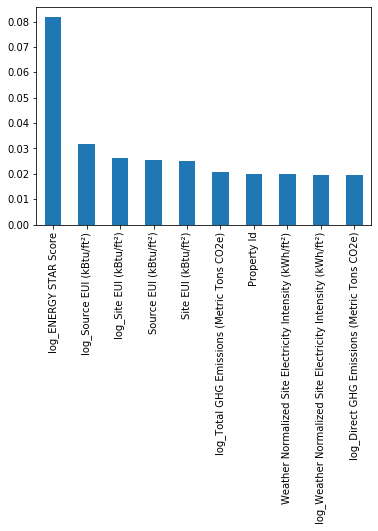

In [42]:
model = ExtraTreesClassifier()
model.fit(features, targets)

feat_importances = pd.Series(model.feature_importances_, index=features.columns)

et_clf = feat_importances.nlargest(10).index

feat_importances.nlargest(10).plot(kind = 'bar')
plt.show()

### Select features with chi2

In [0]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(features.drop(columns = features.columns[(features < 0).any()], axis = 1), targets)

In [0]:
chi2_scores = pd.DataFrame(fit.scores_)

In [0]:
feature_columns = pd.DataFrame(features.drop(columns = features.columns[(features < 0).any()], axis = 1).columns)

In [0]:
features_scores = pd.concat([feature_columns, chi2_scores], axis = 1)

In [0]:
features_scores.columns = ['name', 'score']

In [56]:
features_scores.head()

,name,score
0,Order,3.936751e+05
1,Property Id,7.725150e+07
2,DOF Gross Floor Area,1.501708e+21
3,Largest Property Use Type - Gross Floor Area (...,4.519004e+07
4,Year Built,1.159556e+02


In [0]:
feat_chi = features_scores.nlargest(10, 'score').iloc[:, 0]

In [85]:
feat_chi

35           log_Electricity Use - Grid Purchase (kBtu)
14               Electricity Use - Grid Purchase (kBtu)
34                           log_Natural Gas Use (kBtu)
36        log_Weather Normalized Site Electricity (kWh)
9     Weather Normalized Site Electricity Intensity ...
15            Weather Normalized Site Electricity (kWh)
12                               Natural Gas Use (kBtu)
10    Weather Normalized Site Natural Gas Intensity ...
13     Weather Normalized Site Natural Gas Use (therms)
28                             log_DOF Gross Floor Area
Name: name, dtype: object

### Combine top features

In [0]:
et_clf = pd.DataFrame(et_clf)

In [88]:
et_clf

,0
0,log_ENERGY STAR Score
1,log_Source EUI (kBtu/ft²)
2,log_Site EUI (kBtu/ft²)
3,Source EUI (kBtu/ft²)
4,Site EUI (kBtu/ft²)
5,log_Total GHG Emissions (Metric Tons CO2e)
6,Property Id
7,Weather Normalized Site Electricity Intensity ...
8,log_Weather Normalized Site Electricity Intens...
9,log_Direct GHG Emissions (Metric Tons CO2e)


In [0]:
et_clf = et_clf.values

In [0]:
feat_chi = pd.DataFrame(feat_chi)

In [91]:
feat_chi

,name
35,log_Electricity Use - Grid Purchase (kBtu)
14,Electricity Use - Grid Purchase (kBtu)
34,log_Natural Gas Use (kBtu)
36,log_Weather Normalized Site Electricity (kWh)
9,Weather Normalized Site Electricity Intensity ...
15,Weather Normalized Site Electricity (kWh)
12,Natural Gas Use (kBtu)
10,Weather Normalized Site Natural Gas Intensity ...
13,Weather Normalized Site Natural Gas Use (therms)
28,log_DOF Gross Floor Area


In [0]:
feat_chi = feat_chi.values

In [0]:
merged_features = np.concatenate((feat_chi, et_clf))

In [102]:
merged_features

array([['log_Electricity Use - Grid Purchase (kBtu)'],
       ['Electricity Use - Grid Purchase (kBtu)'],
       ['log_Natural Gas Use (kBtu)'],
       ['log_Weather Normalized Site Electricity (kWh)'],
       ['Weather Normalized Site Electricity Intensity (kWh/ft²)'],
       ['Weather Normalized Site Electricity (kWh)'],
       ['Natural Gas Use (kBtu)'],
       ['Weather Normalized Site Natural Gas Intensity (therms/ft²)'],
       ['Weather Normalized Site Natural Gas Use (therms)'],
       ['log_DOF Gross Floor Area'],
       ['log_ENERGY STAR Score'],
       ['log_Source EUI (kBtu/ft²)'],
       ['log_Site EUI (kBtu/ft²)'],
       ['Source EUI (kBtu/ft²)'],
       ['Site EUI (kBtu/ft²)'],
       ['log_Total GHG Emissions (Metric Tons CO2e)'],
       ['Property Id'],
       ['Weather Normalized Site Electricity Intensity (kWh/ft²)'],
       ['log_Weather Normalized Site Electricity Intensity (kWh/ft²)'],
       ['log_Direct GHG Emissions (Metric Tons CO2e)']], dtype=object)

In [0]:
merged_features = np.unique(merged_features)

In [104]:
merged_features

array(['Electricity Use - Grid Purchase (kBtu)', 'Natural Gas Use (kBtu)',
       'Property Id', 'Site EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity (kWh)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'log_DOF Gross Floor Area',
       'log_Direct GHG Emissions (Metric Tons CO2e)',
       'log_ENERGY STAR Score',
       'log_Electricity Use - Grid Purchase (kBtu)',
       'log_Natural Gas Use (kBtu)', 'log_Site EUI (kBtu/ft²)',
       'log_Source EUI (kBtu/ft²)',
       'log_Total GHG Emissions (Metric Tons CO2e)',
       'log_Weather Normalized Site Electricity (kWh)',
       'log_Weather Normalized Site Electricity Intensity (kWh/ft²)'],
      dtype=object)

## Standard Scaler

In [0]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

In [0]:
scaler = StandardScaler()

In [0]:
X_scl = scaler.fit_transform(X)
X_test_scl = scaler.fit_transform(X_test)

X_scl = pd.DataFrame(X_scl, columns = X.columns)
X_test_scl = pd.DataFrame(X_test_scl, columns = X_test.columns)

## Train

In [0]:
# Fit models on Grid SearchCV
def grid_search_fitting(models, parameters, X_train, y_train, X_test, y_test): 
  scores = ['max_error', 'neg_mean_squared_error', 'r2']
  
  for score in scores:
    clf = GridSearchCV(estimator = models, scoring = score, param_grid = parameters, cv = 5, iid = False)

    clf.fit(X_train, y_train)
    
    score_test = clf.best_estimator_.score(X_test, y_test) 
        

    print(score)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print("\n")

  print('Score on test: ', score_test)
  print("\n")
  
  return clf

In [127]:
Log_regresssion_param = {'fit_intercept': [True,False], 'normalize': [True,False], 'copy_X': [True, False]}
grid_search_fitting(LinearRegression(), Log_regresssion_param, X_scl[merged_features], y, X_test_scl[merged_features], y_test)

max_error
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
-50.2149239623718


neg_mean_squared_error
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
-207.52936838403235


r2
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
0.7674903326338154


Score on test:  -2.988535700661987e+17




GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid=False, n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [128]:
Lin_regresssion_param = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'epsilon': [0.001, 0.01, 0.1, 1, 2, 5]}
grid_search_fitting(LinearSVR(), Lin_regresssion_param, X_scl[merged_features], y, X_test_scl[merged_features], y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

max_error
LinearSVR(C=0.01, dual=True, epsilon=0.1, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
-49.2293266694796




/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

neg_mean_squared_error
LinearSVR(C=0.1, dual=True, epsilon=5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
-279.3312673753353




/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

r2
LinearSVR(C=0.1, dual=True, epsilon=5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
0.6873136261815208


Score on test:  0.6977173519654001




/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=1000,
                                 random_state=None, tol=0.0001, verbose=0),
             iid=False, n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'epsilon': [0.001, 0.01, 0.1, 1, 2, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)